# Lab Activity 9: Reinforcement learning

The goal of this activity is to explore the concepts of reinforcement learning
using the OpenAI Gym package.

This activity is adapted from  Aur&eacute;lien G&eacute;ron, *Hands-On Machine Learning with Scikit-Learn and TensorFlow*, 2017, Chapter 16. (The code can be retreived from [the book's github page](https://github.com/ageron/handson-ml). 
However, the code available there differs from what appears in the book in several places, and 
in some cases to revert back to version in the book.) 


## 1. Overview of concepts

G&eacute;ron says, "In Reinforcement Learning, a software *agent*
makes *observations* and takes *actions* within an
*environment*, and in return it receives *rewards*" (pg 446).
These terms are chosen to be general enough to be applicable in the real world
as well as in virtual worlds. 
Taking them one at a time,

- An *agent* is a software entity or the real-world entity (such as a robot
or device) that the software controls.

- *Observations* are the readings fed into the agent, the inputs the agent uses
to determine the next action.
They could, for example, come from sensors.

- *Actions* are the agent's outputs, the things the agent does.

- The *environment* is the real or virtual setting from which the observations are made
and which the actions affect.

- The *reward* is what we want to maximize.
Rewards also can be negative, in which case we minimize the absolute value.

The most important of term is *policy*, which is the algorithm used by the agent.
A policy can be hard-coded---that is, devised by a human, as we usually
think of programming; 
or it can be learned/trained.
Training can be thought of as a search in the *policy space*, the set of 
possible policies.
That search could be done by genetic algorithms, or 
using a *policy gradient*, similar to how we have used gradient descent
in other techniques.


## 2. The OpenAI Gym package

To train an agent or policy, you need an environment for the agent to interact with.
An environment can be part of the real world, but of course there are many advantages to
simulated environments. 
(As G&eacute;ron says, "If a robot falls off a cliff, you can't just click `undo`" (pg 449).)
We'll be using the `gym` package from the [OpenAI project](https://gym.openai.com/)
which contains simulated environments and library functions to interact with them.

First, import some packages and define a few functions our code will need later:

In [3]:

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

    
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)



We're going to start by using an environment called CartPole, which is... a simulated *cart*... with a *pole*.
As described in the [OpenAI Gym documentation](https://gym.openai.com/envs/CartPole-v0/),

> A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

There also exists a Ms Pacman environment, which would have been more exciting. 
Unfortunately the `atari` dependency that it needs won't install correctly with our current version of Python 3.

Actually the "Cart Pole" is a classic problem. 
Physcially it's an inverted pendulum, that is, it's a pendulum with a pivot on the bottom.
Keeping the pole centered is difficult, but we're going to develop a policy to do it.

You can see what the cart does with this example:

In [ ]:
import gym
env = gym.make('CartPole-v0')
env.reset()
for _ in range(1000):
    env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()

Let's take this apart. Resetting the environment gives us
an initial observation. For the Cart Pole environment, an observation
consists in the horizontal position of the cart, the cart's velocity,
the angle of the pole (in radians (I think) from vertical),
and the angular velocity of the pole.

In [14]:
obs = env.reset()
obs

array([-0.01684876, -0.03503493,  0.04107626, -0.02084707])

The following code makes the visualization cleaner.

In [16]:
from PIL import Image, ImageDraw

try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True   # no problem, let's use OpenAI gym's rendering function
except Exception:
    openai_cart_pole_rendering = False  # probably no X server available, let's use our own rendering function

def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        # use OpenAI gym's rendering function
        return env.render(mode="rgb_array")
    else:
        # rendering for the cart pole environment (in case OpenAI gym can't do it)
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2
        bg_col = (255, 255, 255)
        cart_col = 0x000000 # Blue Green Red
        pole_col = 0x669acc # Blue Green Red

        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len * np.sin(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)

def plot_cart_pole(env, obs):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

We can look at the state of the environment by rendering an image for it.

<IPython.core.display.Javascript object>


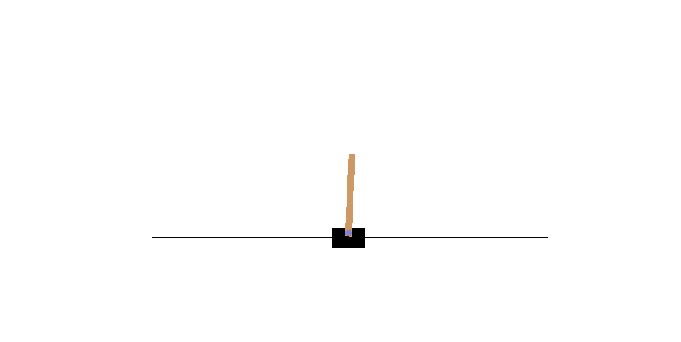

In [18]:
img = env.render(mode="rgb_array")
#print(img)
plt.figure(figsize=(5,4))
plt.imshow(img)
plt.axis("off")
plt.show()

What actions are possible in this environment?
That's defined by the environment's *action space*, which we can look at as an attribute of the environment.

In [19]:
env.action_space

Discrete(2)

This means that there is a discrete (rather than continuous) set of actions, and specifically there
are two of them.
In Cart Pole, these two actions correspond to "applying a force of +1 or -1 to the cart", as described
earlier. 
Let's try moving the pole to the right.
This will return a new observation, as well as a reward, an indicator of whether we're done,
and "other" info.

In [34]:
print(obs) # Print the original observation again for convenience
action = 0
obs, reward, done, info = env.step(action)
print(obs)
print(reward)
print(done)
print(info)

[-0.16964869 -1.95246778  0.22049903  2.98950058]
[-0.20869805 -2.14805886  0.28028904  3.34008653]
0.0
True
{}


/usr/lib/python3.4/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


What does the observation tell you about how the environment has changed?

In this environment, the goal is to keep the pole from tipping over as long as possible.
The `done` result will be `True` when the cart leaves the environment or the pole leans too much.
Thus the `reward` is given merely for keeping the game alive---it will be 1.0 at every step 
as long as the episode isn't over.
In this case the `info` is empty, but in general (according to G&eacute;ron, pg 452):

> This dictionary may provide extra debug information in other environments.
This data should not be used for training (it would be cheating).

Let's look at it now:

<IPython.core.display.Javascript object>


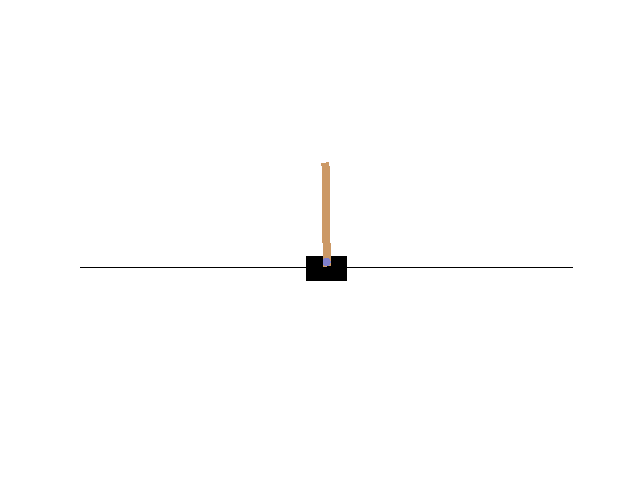

(-0.5, 599.5, 399.5, -0.5)

In [28]:
plt.close()  # or else nbagg sometimes plots in the previous cell
img = render_cart_pole(env, obs)
plt.imshow(img)
plt.axis("off")


Visually nothing much seems to have changed.
This time, let's repeat an action until there are significant changes.
This code keeps pushing the cart left, and stops when `done` is `True`, that is,
when the pole tips over.

In [56]:
obs = env.reset()
sum = 0
while True:
    obs, reward, done, info = env.step(0)
    obs, reward, done, info = env.step(1)
    sum += 2
    if done:
        print (sum)
        break

48


/usr/lib/python3.4/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Look at it:

<IPython.core.display.Javascript object>


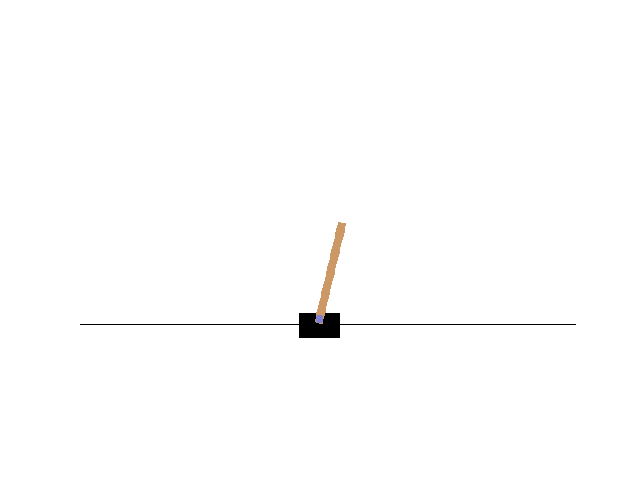

(-0.5, 599.5, 399.5, -0.5)

In [57]:
plt.close()  # or else nbagg sometimes plots in the previous cell
img = render_cart_pole(env, obs)
plt.imshow(img)
plt.axis("off")


All right, the ol' pole is tipped over now.
Go back, reset the environment, and change the code so that it pushes the car to the right instead.



## 3. A hard-coded policy

Now let's make a first attempt at a policy to solve the problem.
Of course our real goal is to *train* a policy, but in principle we can hard code one
of our own devising. 
The following encodes a policy of just pushing the cart in the same direction that the pole is currently 
(slightly) tilting.
The intuition, I guess, is that we're trying to move the pole's pivot under its center of gravity.

So that we can watch what happens, we store the rendered image of each step
in a list, where they are like frames in an animation.

In [82]:
frames = []

n_max_steps = 1000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
    img = render_cart_pole(env, obs)
    frames.append(img)

    # hard-coded policy
    position, velocity, angle, angular_velocity = obs
    if angular_velocity < 0:
        action = 0
    else:
        action = 1
    
    if position > .25:
        action = 1
    if position < -.25:
        action = 0
        
    if angle < -.15:
        action = 1
    if angle > .15:
        action = 0

    obs, reward, done, info = env.step(action)
#     if done:
#         print (len(frames))
#         print (angle)
#         break

/usr/lib/python3.4/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Let's watch it. 
(I put this in a separate cell so you could watch the animation of the same run of the game several times.)

<IPython.core.display.Javascript object>


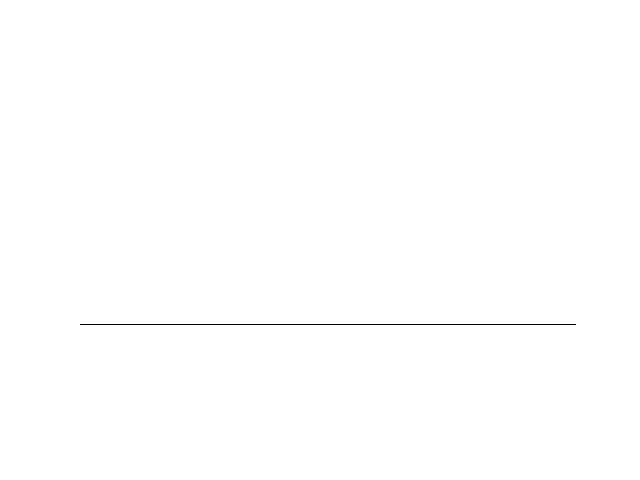

In [83]:
video = plot_animation(frames)
plt.show()

That doesn't work very well.
Make some changes with the hard-coded policy to see if you can make it stay up for longer. Also, you can comment out the `if done : break ` lines to see what happens if your policy keeps on being used even after the pole is tilted too much.

## 4. A neural net policy

Now let's make a policy that uses a neural net to control the cart.
The input units will be the observations, and the output will be the action.
Read through this code (which uses `tensorflow`) and see how well you can figure 
out how this works.

In [84]:
import tensorflow as tf

# 1. Specify the network architecture
n_inputs = 4  # == env.observation_space.shape[0]
n_hidden = 4  # it's a simple task, we don't need more than this
n_outputs = 1 # only outputs the probability of accelerating left
initializer = tf.variance_scaling_initializer()

# 2. Build the neural network
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu,
                         kernel_initializer=initializer)
outputs = tf.layers.dense(hidden, n_outputs, activation=tf.nn.sigmoid,
                          kernel_initializer=initializer)

# 3. Select a random action based on the estimated probabilities
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

init = tf.global_variables_initializer()

It has one hidden layer with four units, and the output layer has one unit,
since our output is moving the cart to the left or right.
However, the output unit doesn't give the action exactly, but rather gives
the probability of an action.
Specifically, the output is a probability $p$ of moving the cart left 
(or $p-1$ of moving the car right).
The `tf.multinomial` business in the code does random sampling of
a multinomial distribution to determine and action based on the 
probability returned by the output unit.

The reason for the randomness is training.
The current state of the network/policy will indicate one action or the other
is preferrable, but just in case that's *not* the right thing to do at this point,
there is a chance that our agent will pick the other possible action.
If that other action turns out to be better, then that observation can
be used to train the policy better.
The network "explores" new ways to respond to an observation.

Run this policy on one round of the game, and then watch it.
The weights of the network are set up randomly.

In [85]:
n_max_steps = 1000
frames = []

with tf.Session() as sess:
    init.run()
    obs = env.reset()
    for step in range(n_max_steps):
        img = render_cart_pole(env, obs)
        frames.append(img)
        action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
        obs, reward, done, info = env.step(action_val[0][0])
        if done:
            break

env.close()

<IPython.core.display.Javascript object>


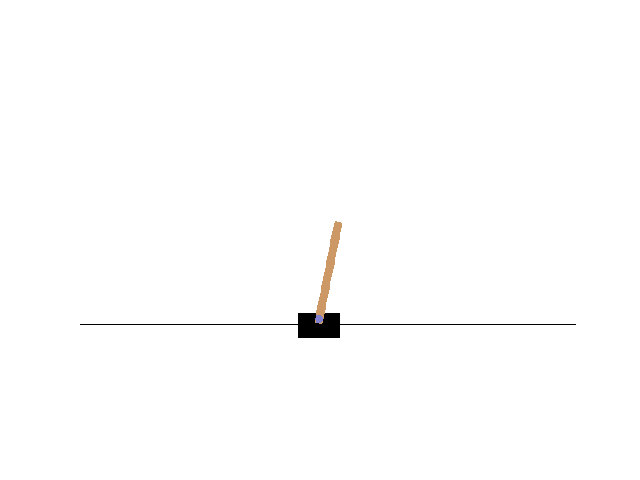

In [86]:
video = plot_animation(frames)
plt.show()

How did this do? Since your network was set up randomly, I can't predict for
certain, but I'm guessing not very well.
You can try again.
Remember that running the `plt.show()` cell multiply will replay the same video, but
re-running the prior cell will make a new network and run a new round of the game.


We need to train the neural net. 
The following code uses parts of `tensorflow` that we didn't get to,
but the idea is that we're adding a trainer and something to optimize.

In [87]:
import tensorflow as tf

reset_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1

learning_rate = 0.01

initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.float32, shape=[None, n_outputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits) # probability of action 0 (left)
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(cross_entropy)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Let's run and watch this one.

In [93]:
n_max_steps = 1000
frames = []

with tf.Session() as sess:
    init.run()
    obs = env.reset()
    for step in range(n_max_steps):
        img = render_cart_pole(env, obs)
        frames.append(img)
        action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
        obs, reward, done, info = env.step(action_val[0][0])
        if done:
            break

env.close()

<IPython.core.display.Javascript object>


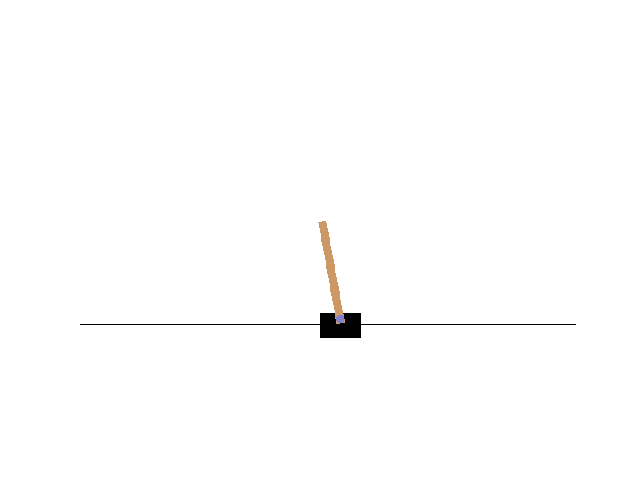

In [94]:
video = plot_animation(frames)
plt.show()

That one run still relies on the network's random initialization.
But if we run it many times, it will train.
To speed things, up train it in 10 environments in parallel, each with 1000 iterations


In [95]:
n_environments = 10
n_iterations = 1000

envs = [gym.make("CartPole-v0") for _ in range(n_environments)]
observations = [env.reset() for env in envs]

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        target_probas = np.array([([1.] if obs[2] < 0 else [0.]) for obs in observations]) # if angle<0 we want proba(left)=1., or else proba(left)=0.
        action_val, _ = sess.run([action, training_op], feed_dict={X: np.array(observations), y: target_probas})
        for env_index, env in enumerate(envs):
            obs, reward, done, info = env.step(action_val[env_index][0])
            observations[env_index] = obs if not done else env.reset()
    saver.save(sess, "./my_policy_net_basic.ckpt")

for env in envs:
    env.close()

In [96]:
def render_policy_net(model_path, action, X, n_max_steps = 1000):
    frames = []
    env = gym.make("CartPole-v0")
    obs = env.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            img = render_cart_pole(env, obs)
            frames.append(img)
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
    env.close()
    return frames        

INFO:tensorflow:Restoring parameters from ./my_policy_net_basic.ckpt


<IPython.core.display.Javascript object>


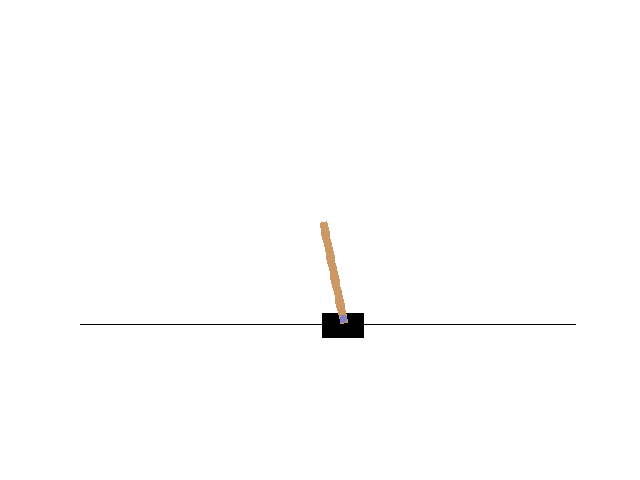

In [98]:
frames = render_policy_net("./my_policy_net_basic.ckpt", action, X)
video = plot_animation(frames)
plt.show()

The neural net has learned the policy we had previous hand-coded: move the cart in the direction of the tilt.
Of course, that's not a very good policy.
Let's see if we can do better.

## 5. Policy gradients

*Policy gradient (PG) algorithms* train policies by following a gradient.
As a policy is trained, we want good actions to increase in probability and
bad actions to decrease.
The difficulty is that we don't know whether a policy is good until several
steps later when its long-term effects are seen. 
This is the *credit assignment problem*: 
If a series of actions result in a reward (or negaitive reward), which of the actions
should be given credit for the reward and hence increased in probability?

The *discount rate* is the amount of reward applied across steps to each action.
For discount rate $r$ and a given reward $d$, $d$ is applied to the immediately preceding action, $r d$ to the action after that, $r^2 d$ to the action after that, etc.
Alternately, if $d_i$ is the reward for step $i$, then the reward applied to
the action at step $j$ is $\sum_k r^k d_{j+k}$.

*REINFORCE algorithms* are a class of PG algorithms, summarized by G&eacute;ron as follows:

> 1. First, let the neural network policy play the game several times and at each step
compute the gradients that would make the chosen action even more likely, but
don't apply these gradients yet.
2. Once you have run several episodes, compute each action's score.
3. If an action's score is positive, it means that the action was good and you want
to apply the gradients computed earlier to make the action even more likely to be chosen in the future. [The opposite for negative gradients.]
4. Compute the mean of all the resulting gradient vectors, and use it to perform a Gradient Descent step. (Pg 457)

Here is the code for this approach.
One difference is that the optimizer uses `compute_gradients()` instead of
`minimize()`.

In [99]:
reset_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1

learning_rate = 0.01

initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits)  # probability of action 0 (left)
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

y = 1. - tf.to_float(action)
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Functions to calculate discounts and apply rewards:

In [100]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

Try these to understand how those functions work:

In [101]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22., -40., -50.])

In [102]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

Now, train the policy:

In [103]:
env = gym.make("CartPole-v0")

n_games_per_update = 10
n_max_steps = 1000
n_iterations = 250
save_iterations = 10
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print("\rIteration: {}".format(iteration), end="")
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)})
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./my_policy_net_pg.ckpt")

Iteration: 249

Be patient as those iterations tick by. When they are done, you should have
a policy that can balance the pole.

In [104]:
env.close()

INFO:tensorflow:Restoring parameters from ./my_policy_net_pg.ckpt
200


<IPython.core.display.Javascript object>


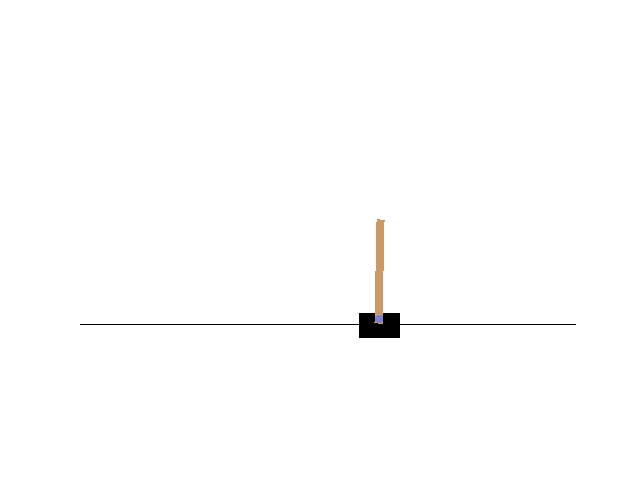

In [112]:
frames = render_policy_net("./my_policy_net_pg.ckpt", action, X, n_max_steps=10000)
print(len(frames))
video = plot_animation(frames)

To see more about Cart Pole, including other solutions, look 
[here](http://gym.openai.com/envs/CartPole-v0/).